# Customer Personality Analysis
고객 특성 분석
https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

<br>

https://www.kaggle.com/code/seungbumlim/how-to-select-the-optimal-number-for-pca-kmeans/notebook
    
https://www.kaggle.com/code/ahmetburabua/customer-personality-analysis-clustering/notebook

<br>

### ~8/12
- 군집화 정리

<br>

#### loading dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date

mk = pd.read_csv("marketing_campaign.csv")

In [2]:
mk.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


<br>

#### data preprocessing

1. Year_Birth 태어난 년도  → Age 변수 생성 후 삭제

In [3]:
# converting columns to DateTime format
mk['Year_Birth'] = pd.to_datetime(mk['Year_Birth'], format ='%Y') # int 자료형을 datetime으로 변환

2. Education 학력

In [4]:
# 교육 수준을 세 그룹으로 세분화
mk["Education_Level"]=mk["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", 
                                               "Graduation":"Graduate", 
                                               "Master":"Postgraduate", "PhD":"Postgraduate"})

In [5]:
###Education_Level과 정보가 중복되어 기존의 Education은 제거했습니다.

3. Marital_Status 결혼상태

In [6]:
# 결혼상태에 따른 파트너 유무
mk["Partner"]=mk["Marital_Status"].replace({"Married":"Yes", "Together":"Yes", 
                                            "Absurd":"No", "Widow":"No", "YOLO":"No", "Divorced":"No", "Single":"No","Alone":"No"})

In [7]:
###Partner가 기존의 Marital_Status의 정보를 포함한다고 생각해 Marital_Status는 제거했습니다.

4. Income

In [8]:
#income 결측치 제거
mk = mk.dropna()

In [9]:
# income 이상치 제거
b = mk[mk['Income'] > 140000].index
mk.drop(b, inplace=True)

5. Kidhome & Teenhome

In [10]:
# 가구 내 총 자녀 수
mk["Children"] = mk["Kidhome"] +  mk["Teenhome"]

In [11]:
# 가족수
mk["Family_Size"] = mk["Partner"].replace({"No": 1, "Yes":2})+ mk["Children"]

In [12]:
#부모인지 아닌지
mk["Is_Parent"] = np.where(mk.Children> 0, 1, 0)  #총 자녀 수가 0보다 크면 1 아니면 0

In [13]:
mk.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Education_Level,Partner,Children,Family_Size,Is_Parent
0,5524,1957-01-01,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,3,11,1,Graduate,No,0,1,0
1,2174,1954-01-01,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,3,11,0,Graduate,No,2,3,1
2,4141,1965-01-01,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,3,11,0,Graduate,Yes,0,2,0
3,6182,1984-01-01,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,3,11,0,Graduate,Yes,1,3,1
4,5324,1981-01-01,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,3,11,0,Postgraduate,Yes,1,3,1


6. Dt_Customer 최초 고객 등록일

In [14]:
# object 자료형을 datetime으로 변환
mk['Dt_Customer'] = pd.to_datetime(mk['Dt_Customer'], dayfirst=True)

In [15]:
#가입일수 "T"
from datetime import date
last_date = date(2022,8,7)
mk["T"] = pd.to_numeric(mk["Dt_Customer"].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast="integer")

In [16]:
####가입한 날짜, 월 및 연도에 대한 열 추가 안함


# mk['Year_Joined'] = mk['Dt_Customer'].dt.year # 연도 추출
# mk['Month_Joined'] = mk['Dt_Customer'].dt.strftime("%B") # strftime: 날짜 형식 변환 %B:locale 월
# mk['Day_Joined'] = mk['Dt_Customer'].dt.day_name() # day_name: 요일을 문자열로 추출



In [17]:
mk["Dt_Customer"].dt.year.min() , mk["Dt_Customer"].dt.year.max()

# 연령 및 연도 생성_고객
mk['Age'] = (mk["Dt_Customer"].dt.year.max()) - (mk['Year_Birth'].dt.year)

#고객 중 가장 최근 가입일을 기준으로, 고객의 체류 연도 변수
mk['Years_Customer'] = (mk["Dt_Customer"].dt.year.max()) - (mk['Dt_Customer'].dt.year) 
#고객의 체류 기간 변수
mk['Days_Customer'] = (mk["Dt_Customer"].max()) - (mk['Dt_Customer'])                  

In [18]:
#고객의 체류 기간 정수형으로 변환
mk['Days_Customer'] = mk['Days_Customer'].dt.days.astype('int16')

In [19]:
mk.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Response,Education_Level,Partner,Children,Family_Size,Is_Parent,T,Age,Years_Customer,Days_Customer
0,5524,1957-01-01,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,1,Graduate,No,0,1,0,3624,57,2,663
1,2174,1954-01-01,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,Graduate,No,2,3,1,3074,60,0,113
2,4141,1965-01-01,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,Graduate,Yes,0,2,0,3273,49,1,312
3,6182,1984-01-01,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,Graduate,Yes,1,3,1,3100,30,0,139
4,5324,1981-01-01,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,Postgraduate,Yes,1,3,1,3122,33,0,161


7. Age

In [20]:
# age 이상치 제거
a = mk[mk['Age'] >= 100].index
mk.drop(a, inplace=True)

In [21]:
mk[mk['Age'] >= 100].index

Int64Index([], dtype='int64')

In [22]:
# 나이에 따른 그룹 나누기
mk['Age_Group'] = pd.cut(x = mk['Age'], bins = [1, 17, 24, 44, 64, 150],
                         labels = ['Under 18','Young adult','Adult','Middel Aged','Senior Citizen'])

In [23]:
mk.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Education_Level,Partner,Children,Family_Size,Is_Parent,T,Age,Years_Customer,Days_Customer,Age_Group
0,5524,1957-01-01,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,Graduate,No,0,1,0,3624,57,2,663,Middel Aged
1,2174,1954-01-01,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,Graduate,No,2,3,1,3074,60,0,113,Middel Aged
2,4141,1965-01-01,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,Graduate,Yes,0,2,0,3273,49,1,312,Middel Aged
3,6182,1984-01-01,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,Graduate,Yes,1,3,1,3100,30,0,139,Adult
4,5324,1981-01-01,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,Postgraduate,Yes,1,3,1,3122,33,0,161,Adult


8. Mnt

In [24]:
mk.rename(columns = {'MntGoldProds':'MntGoldProducts'}, inplace = True)

In [25]:
#제품에 지출된 총액
mk['TotalMntSpent'] = mk['MntWines'] + mk['MntFruits'] + mk['MntMeatProducts'] + mk['MntFishProducts'] + mk['MntSweetProducts'] + mk['MntGoldProducts']

In [26]:
#총 구매 건수
mk['TotalNumPurchases'] = mk['NumWebPurchases'] + mk['NumCatalogPurchases'] + mk['NumStorePurchases'] + mk['NumDealsPurchases']

In [27]:
# 승인된 총 캠페인 수
mk['Total_Acc_Cmp'] = mk['AcceptedCmp1'] + mk['AcceptedCmp2'] + mk['AcceptedCmp3'] + mk['AcceptedCmp4'] + mk['AcceptedCmp5'] + mk['Response']

In [28]:
# 공통적으로 제거
mk.drop(['ID','Z_CostContact','Z_Revenue','Year_Birth','Dt_Customer'], axis=1, inplace=True)

In [29]:
# 판단으로 제거
mk.drop(['Education','Marital_Status'], axis=1, inplace=True)

In [30]:
mk.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProducts,...,Family_Size,Is_Parent,T,Age,Years_Customer,Days_Customer,Age_Group,TotalMntSpent,TotalNumPurchases,Total_Acc_Cmp
0,58138.0,0,0,58,635,88,546,172,88,88,...,1,0,3624,57,2,663,Middel Aged,1617,25,1
1,46344.0,1,1,38,11,1,6,2,1,6,...,3,1,3074,60,0,113,Middel Aged,27,6,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,2,0,3273,49,1,312,Middel Aged,776,21,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,3,1,3100,30,0,139,Adult,53,8,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,3,1,3122,33,0,161,Adult,422,19,0


In [31]:
mk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2205 entries, 0 to 2239
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Income               2205 non-null   float64 
 1   Kidhome              2205 non-null   int64   
 2   Teenhome             2205 non-null   int64   
 3   Recency              2205 non-null   int64   
 4   MntWines             2205 non-null   int64   
 5   MntFruits            2205 non-null   int64   
 6   MntMeatProducts      2205 non-null   int64   
 7   MntFishProducts      2205 non-null   int64   
 8   MntSweetProducts     2205 non-null   int64   
 9   MntGoldProducts      2205 non-null   int64   
 10  NumDealsPurchases    2205 non-null   int64   
 11  NumWebPurchases      2205 non-null   int64   
 12  NumCatalogPurchases  2205 non-null   int64   
 13  NumStorePurchases    2205 non-null   int64   
 14  NumWebVisitsMonth    2205 non-null   int64   
 15  AcceptedCmp3         

In [32]:
mk.to_csv('new.csv', index= False)

In [33]:
##상관관계 분석은 넘어가겠습니다.

#### pca 전 데이터 전처리

1. 수치형 변수 정규화

In [34]:
# 원래 데이터 복사
mk_scaled = mk.copy()

In [35]:
# 집계가 포함된 변수들 삭제
## 'Total_Acc_Cmp' 와 'TotalMntSpent'에 정보 포함
drop_cols = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response',
             'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProducts']
mk_scaled.drop(columns = drop_cols, axis = 1, inplace = True)

print(mk_scaled.shape)

(2205, 23)


In [36]:
mk_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2205 entries, 0 to 2239
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Income               2205 non-null   float64 
 1   Kidhome              2205 non-null   int64   
 2   Teenhome             2205 non-null   int64   
 3   Recency              2205 non-null   int64   
 4   NumDealsPurchases    2205 non-null   int64   
 5   NumWebPurchases      2205 non-null   int64   
 6   NumCatalogPurchases  2205 non-null   int64   
 7   NumStorePurchases    2205 non-null   int64   
 8   NumWebVisitsMonth    2205 non-null   int64   
 9   Complain             2205 non-null   int64   
 10  Education_Level      2205 non-null   object  
 11  Partner              2205 non-null   object  
 12  Children             2205 non-null   int64   
 13  Family_Size          2205 non-null   int64   
 14  Is_Parent            2205 non-null   int32   
 15  T                    

In [37]:
from sklearn.preprocessing import StandardScaler, normalize

# 수치형 자료에 대해 정규화
scale_cols = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
              'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
              'NumWebVisitsMonth', 'Complain', 'Children', 'Family_Size', 'Is_Parent', 'T',
              'Age', 'Years_Customer', 'Days_Customer','TotalMntSpent', 'TotalNumPurchases', 'Total_Acc_Cmp']

ss = StandardScaler()

for col in scale_cols:
     mk_scaled[col] = ss.fit_transform(mk_scaled[[col]])
    
display(mk_scaled.shape, mk_scaled.head(3))

(2205, 23)

,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,...,Family_Size,Is_Parent,T,Age,Years_Customer,Days_Customer,Age_Group,TotalMntSpent,TotalNumPurchases,Total_Acc_Cmp
0,0.314651,-0.823405,-0.930767,0.310830,0.361479,1.424772,2.628526,-0.562650,0.689203,-0.095673,...,-1.759012,-1.58466,1.527183,1.017189,1.498307,1.527183,Middel Aged,1.679323,1.328161,0.614920
1,-0.254877,1.038757,0.906602,-0.380600,-0.168834,-1.132957,-0.588043,-1.179732,-0.139645,-0.095673,...,0.448513,0.63105,-1.188629,1.273530,-1.417639,-1.188629,Middel Aged,-0.963897,-1.167390,-0.503808
2,0.965354,-0.823405,-0.930767,-0.795458,-0.699147,1.424772,-0.230646,1.288596,-0.554069,-0.095673,...,-0.655250,-1.58466,-0.205999,0.333612,0.040334,-0.205999,Middel Aged,0.281242,0.802782,-0.503808


2. 범주형 변수 라벨 인코딩

In [38]:
num_cols = mk_scaled._get_numeric_data().columns
cat_cols = set(mk_scaled.columns) - set(num_cols)

print(list(cat_cols))

['Education_Level', 'Partner', 'Age_Group']


In [39]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for i in cat_cols:
    mk_scaled[i] = mk_scaled[[i]].apply(le.fit_transform)
    
mk_scaled[cat_cols].head(2)

,Education_Level,Partner,Age_Group
0,0,0,1
1,0,0,1


#### pca

주성분 갯수 선택

In [40]:
mk_scaled.head(2)

,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,...,Family_Size,Is_Parent,T,Age,Years_Customer,Days_Customer,Age_Group,TotalMntSpent,TotalNumPurchases,Total_Acc_Cmp
0,0.314651,-0.823405,-0.930767,0.31083,0.361479,1.424772,2.628526,-0.562650,0.689203,-0.095673,...,-1.759012,-1.58466,1.527183,1.017189,1.498307,1.527183,1,1.679323,1.328161,0.614920
1,-0.254877,1.038757,0.906602,-0.38060,-0.168834,-1.132957,-0.588043,-1.179732,-0.139645,-0.095673,...,0.448513,0.63105,-1.188629,1.273530,-1.417639,-1.188629,1,-0.963897,-1.167390,-0.503808


**the Scree plot을 이용한 선택법(Elbow method)**<br>
주성분이 늘어감에 따라 고유값(eigen value)이 유의미하게 감소하는 elbow point에 해당하는 주성분 수를 선택 --> 사용자가 주관적으로 선택한다는 단점이 있으므로, 아래의 방법들과 함께 사용하였습니다.

- **Kaiser's Rule**<br>
: PCA().fit(your data)을 통해 데이터의 차원 축소를 수행한 뒤, .explained_variance_ 속성을 이용하여 각 주성분의 고유값(eigen value)을 알 수 있습니다. 카이저 규칙은, 고유값이 1을 초과하는 주성분들만 선택하는 방식인데, 요인의 수를 고려하지 않는 지나치게 엄격한 관습적인 방법으로 인해 1번과 3번의 방법과 함께 참고로만 사용하는 것을 권장하고 있습니다.


- **분산비율 선택법**<br>
: 전체 데이터에서 최소 70% 이상의 설명력을 가지는 주성분 갯수를 선택하는 방법입니다.

In [41]:
from sklearn.decomposition import PCA

variance_ratio = {}

for i in range(1, len(mk_scaled.columns)+1):
    pca = PCA(n_components=i)
    pca.fit(mk_scaled)
    variance_ratio[f'n_{i}'] = pca.explained_variance_ratio_.sum()
    
variance_ratio

{'n_1': 0.29974078409883104,
 'n_2': 0.46438849938761106,
 'n_3': 0.5910435632864954,
 'n_4': 0.6504590944897253,
 'n_5': 0.6996922101745089,
 'n_6': 0.7469344812670665,
 'n_7': 0.7909054024050409,
 'n_8': 0.8305461810867951,
 'n_9': 0.8597455421952511,
 'n_10': 0.8828894634557078,
 'n_11': 0.9050000603215429,
 'n_12': 0.9242656951502953,
 'n_13': 0.941799997921284,
 'n_14': 0.9566010373953429,
 'n_15': 0.9701773223585511,
 'n_16': 0.9810733785969395,
 'n_17': 0.9893139703404038,
 'n_18': 0.9948723126286961,
 'n_19': 0.9999999999999999,
 'n_20': 0.9999999999999999,
 'n_21': 0.9999999999999999,
 'n_22': 0.9999999999999999,
 'n_23': 0.9999999999999999}

Elbow Method와 Kaiser's Rule

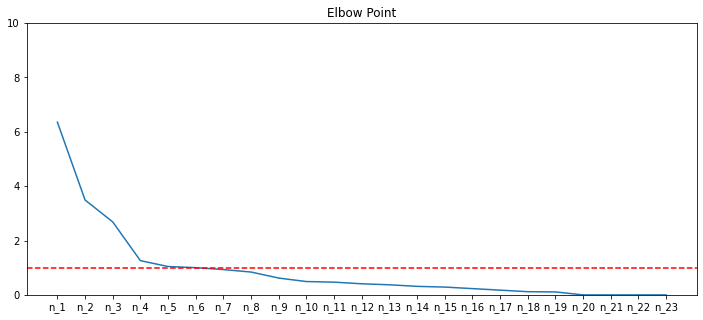

In [42]:
eigen_value = np.sort(pca.explained_variance_)[::-1]

plt.figure(figsize=(12, 5))

plt.plot(variance_ratio.keys(), eigen_value)
plt.ylim(0, 10, 1)
plt.axhline(1, color = 'red', ls = '--')
plt.title('Elbow Point')

plt.show()

In [43]:
print(f'the number of eigenvalue greater than one: {len(eigen_value[eigen_value > 1])}')

the number of eigenvalue greater than one: 6


In [44]:
###6개의 주성분 적절

In [45]:
pca = PCA(n_components = 6, random_state = 42)

pca.fit(mk_scaled)
data_pca = pd.DataFrame(pca.transform(mk_scaled), 
                        columns = (["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"]))

data_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1,2205.0,-6.948335e-17,2.521054,-5.845323,-2.297082,-0.409115,2.023782,6.072543
PC2,2205.0,-4.249561e-17,1.868474,-4.558059,-1.387074,-0.142141,1.245412,5.921459
PC3,2205.0,1.244910e-16,1.638779,-4.676774,-1.161800,0.069354,1.179838,4.908176
PC4,2205.0,7.965410e-17,1.122430,-3.393319,-0.816810,0.049281,0.780989,3.580804
PC5,2205.0,4.919219e-17,1.021739,-3.268379,-0.778217,0.005925,0.817782,3.684719
PC6,2205.0,-3.071365e-17,1.000859,-1.483110,-0.263760,-0.105894,0.064341,10.549891


#### KMeans

In [46]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

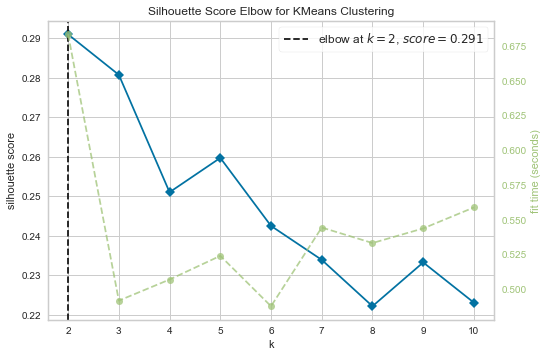

In [47]:
km = KMeans()
Elbow_M = KElbowVisualizer(estimator = km, k = 10, metric='silhouette')
Elbow_M.fit(data_pca)
Elbow_M.show()

plt.show()

**Silhouette method**
- 실루엣 점수는 클러스터 내의 거리와 클러스터 간 거리를 동시에 고려하여 산출되며, 높을수록 좋습니다.
- 대개의 경우에 실루엣 점수가 두번째로 높은 것을 선택하는 것이 좋은 결과를 가져온다고 알려져 있습니다. 따라서 K-means의 K는 3으로 결정하도록 하겠습니다.

In [48]:
# 클러스터링 수행

km = KMeans(n_clusters=3, random_state=42)

yhat_AC = km.fit_predict(data_pca)

data_pca["Clusters"] = yhat_AC   # for evaluating the model
mk["Clusters"]= yhat_AC        # for customers profiling

#### 시각화

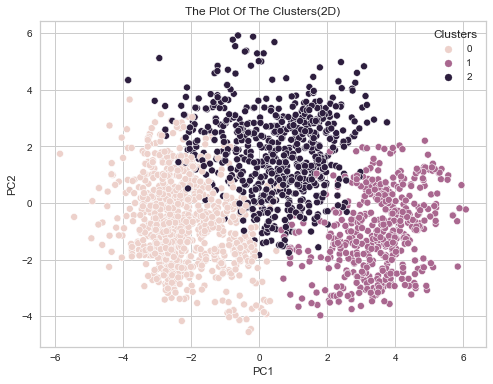

In [49]:
import seaborn as sns
#2차원

plt.figure(figsize=(8,6))

sns.scatterplot(data = data_pca, x = 'PC1', y='PC2', hue='Clusters')
plt.title('The Plot Of The Clusters(2D)')
plt.show()

범주형 변수에 따른 결과

1. 1개의 범주형 변수

age_group
![nn](0807/age_group1.png)

education
![nn](0807/education.png)

partner
![nn](0807/partner.png)

2. 2개의 범주형 변수

age_group & education_level

![nn](0807/a&e.png)

age_group & partner
![nn](0807/a&p.png)

education_level & partner
![nn](0807/e&p.png)

Education_Level과 Partner 중 어느 변수를 범주형 변수로 선택할 것인가

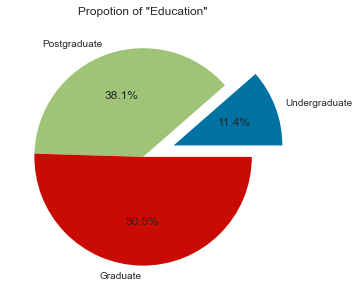

In [50]:
### Education_Level
x = mk['Education_Level'].value_counts().sort_values()
labels = mk['Education_Level'].value_counts().sort_values().index

plt.figure(figsize=(5, 5))
plt.pie(x = x, labels = labels, autopct = '%1.1f%%', wedgeprops = {'linewidth': 5}, explode = [0.3, 0, 0])
plt.title('Propotion of "Education"')
plt.show()

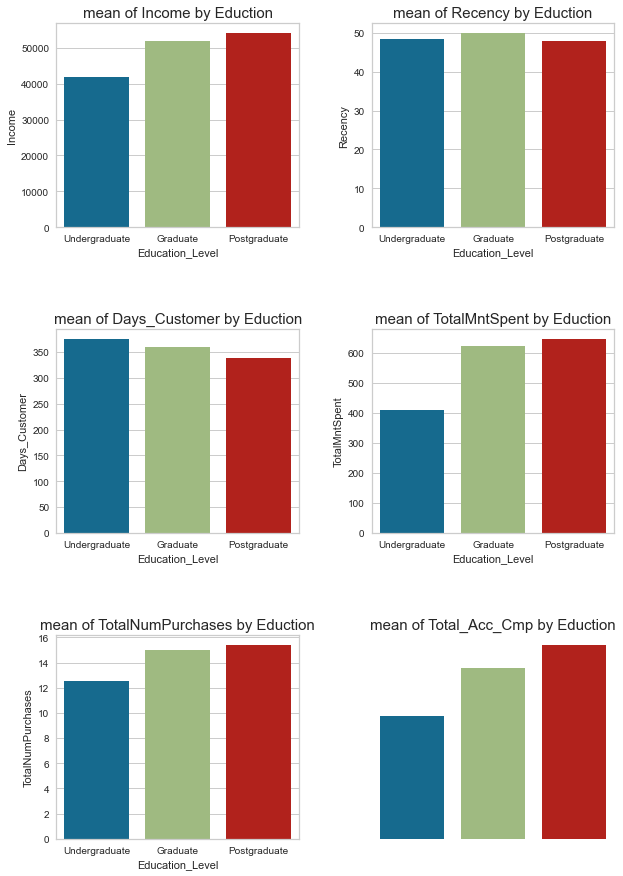

In [51]:
to_barplot = ['Income', 'Recency', 'Days_Customer', 'TotalMntSpent', 'TotalNumPurchases', 'Total_Acc_Cmp']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (10, 15))
axes = axes.flatten()

for col, ax in zip(to_barplot, axes):
    ax = sns.barplot(data = mk, x = 'Education_Level', y = col, ax = ax,
                order = ['Undergraduate', 'Graduate', 'Postgraduate'], ci = None)
    ax.set_title(f'mean of {col} by Eduction', fontsize = 15)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
    
axes[-1].axis('off')    
plt.show()

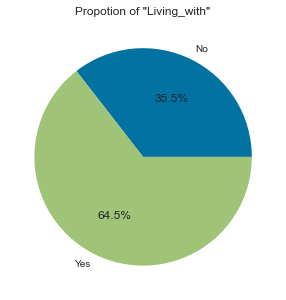

In [52]:
### Partner

x = mk['Partner'].value_counts().sort_values()
labels = mk['Partner'].value_counts().sort_values().index

plt.figure(figsize=(5, 5))
plt.pie(x = x, labels = labels, autopct = '%1.1f%%', wedgeprops = {'linewidth': 5})
plt.title('Propotion of "Living_with"')
plt.show()

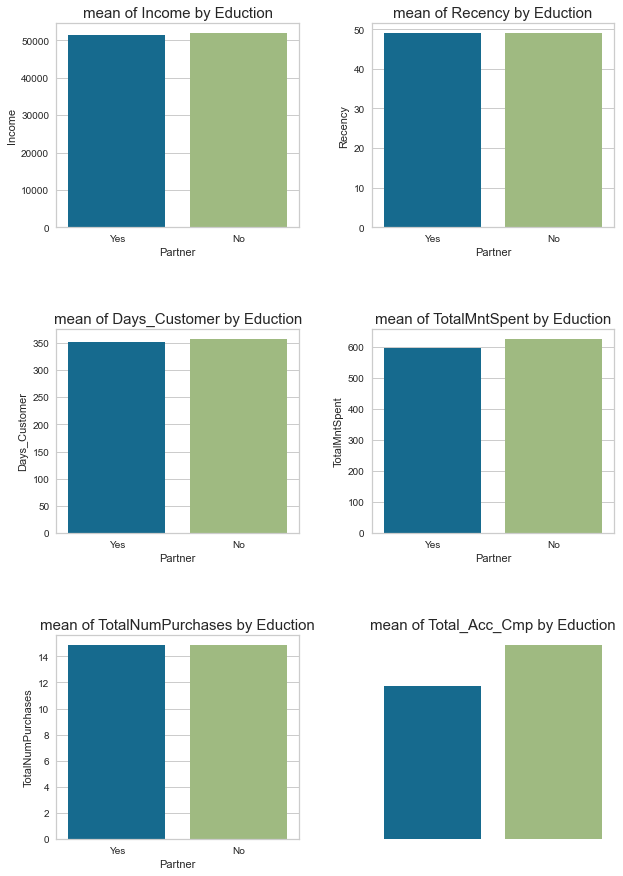

In [53]:
to_barplot = ['Income', 'Recency', 'Days_Customer', 'TotalMntSpent', 'TotalNumPurchases', 'Total_Acc_Cmp']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (10, 15))
axes = axes.flatten()

for col, ax in zip(to_barplot, axes):
    ax = sns.barplot(data = mk, x = 'Partner', y = col, ax = ax,
                order = ['Yes', 'No'], ci = None)
    ax.set_title(f'mean of {col} by Eduction', fontsize = 15)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.3)
    
axes[-1].axis('off')    
plt.show()

→ Education_Level만을 범주형 변수로 선택한다.

<br>

#### 이 범주형 변수를 토대로 '분산비율선택법' 적용해보기

In [54]:
# 'Age_Group','Partner' 제거
mk.drop(['Age_Group','Partner'], axis=1, inplace=True)

In [55]:
# 원래 데이터 복사
mk_scaled = mk.copy()

In [56]:
# 집계가 포함된 변수들 삭제
## 'Total_Acc_Cmp' 와 'TotalMntSpent'에 정보 포함
drop_cols = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Response',
             'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProducts']
mk_scaled.drop(columns = drop_cols, axis = 1, inplace = True)

print(mk_scaled.shape)

(2205, 22)


In [57]:
from sklearn.preprocessing import StandardScaler, normalize

# 수치형 자료에 대해 정규화
scale_cols = ['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
              'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
              'NumWebVisitsMonth', 'Complain', 'Children', 'Family_Size', 'Is_Parent', 'T',
              'Age', 'Years_Customer', 'Days_Customer','TotalMntSpent', 'TotalNumPurchases', 'Total_Acc_Cmp']

ss = StandardScaler()

for col in scale_cols:
     mk_scaled[col] = ss.fit_transform(mk_scaled[[col]])
    
display(mk_scaled.shape, mk_scaled.head(3))

(2205, 22)

,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,...,Family_Size,Is_Parent,T,Age,Years_Customer,Days_Customer,TotalMntSpent,TotalNumPurchases,Total_Acc_Cmp,Clusters
0,0.314651,-0.823405,-0.930767,0.310830,0.361479,1.424772,2.628526,-0.562650,0.689203,-0.095673,...,-1.759012,-1.58466,1.527183,1.017189,1.498307,1.527183,1.679323,1.328161,0.614920,1
1,-0.254877,1.038757,0.906602,-0.380600,-0.168834,-1.132957,-0.588043,-1.179732,-0.139645,-0.095673,...,0.448513,0.63105,-1.188629,1.273530,-1.417639,-1.188629,-0.963897,-1.167390,-0.503808,0
2,0.965354,-0.823405,-0.930767,-0.795458,-0.699147,1.424772,-0.230646,1.288596,-0.554069,-0.095673,...,-0.655250,-1.58466,-0.205999,0.333612,0.040334,-0.205999,0.281242,0.802782,-0.503808,1


In [58]:
num_cols = mk_scaled._get_numeric_data().columns
cat_cols = set(mk_scaled.columns) - set(num_cols)

print(list(cat_cols))

['Education_Level']


In [59]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for i in cat_cols:
    mk_scaled[i] = mk_scaled[[i]].apply(le.fit_transform)
    
mk_scaled[cat_cols].head(2)

,Education_Level
0,0
1,0


분산비율 선택법 수행

In [60]:
from sklearn.decomposition import PCA

variance_ratio = {}

for i in range(1, len(mk_scaled.columns)+1):
    pca = PCA(n_components=i)
    pca.fit(mk_scaled)
    variance_ratio[f'n_{i}'] = pca.explained_variance_ratio_.sum()
    
variance_ratio

{'n_1': 0.3094536008759108,
 'n_2': 0.48458001485099816,
 'n_3': 0.6144140931038787,
 'n_4': 0.6691631062659027,
 'n_5': 0.7174258433836227,
 'n_6': 0.7647198346209817,
 'n_7': 0.8092911666962134,
 'n_8': 0.8472243222063198,
 'n_9': 0.8758137092312175,
 'n_10': 0.8984735935427899,
 'n_11': 0.920211595451935,
 'n_12': 0.9378199079650323,
 'n_13': 0.9516694956781784,
 'n_14': 0.9643083214861955,
 'n_15': 0.9742548159243003,
 'n_16': 0.9829669476412212,
 'n_17': 0.9894269227031596,
 'n_18': 0.994927968715361,
 'n_19': 0.9999999999999997,
 'n_20': 0.9999999999999997,
 'n_21': 0.9999999999999997,
 'n_22': 0.9999999999999997}

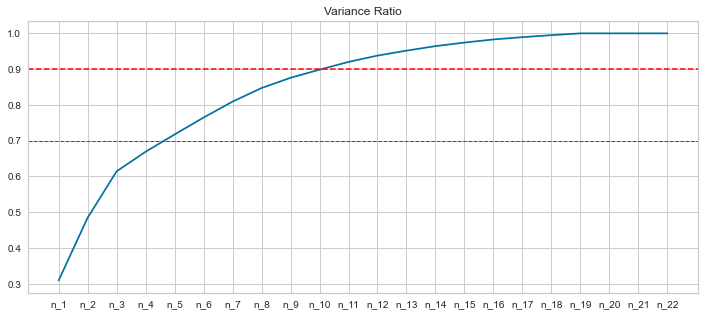

In [61]:
plt.figure(figsize = (12, 5))

plt.plot(variance_ratio.keys(), variance_ratio.values())
plt.axhline(0.7, color = 'red', ls = '--', lw = 1)
plt.axhline(0.9, color = 'red', ls = '--', lw = 1.5)
plt.title("Variance Ratio")

plt.show()

이론적으로 분산비율은 적어도 70% 이상을 요구하고 있습니다. 주성분 4개의 경우 거의 70%이기 때문에 확실히 70% 이상의 분산 설명력을 갖도록 5개의 주성분을 선택하는 것이 적절하다고 판단됩니다.

따라서 아래와 같이 5개의 주성분을 이용하여 차원 축소 및 값 변형된 새로운 데이터 프레임을 생성하였습니다.

In [62]:
pca = PCA(n_components = 5, random_state = 42)

pca.fit(mk_scaled)
data_pca = pd.DataFrame(pca.transform(mk_scaled), 
                        columns = (["PC1", "PC2", "PC3", "PC4", "PC5"]))

data_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1,2205.0,2.064360e-17,2.562679,-5.760256,-2.434857,-0.254268,2.166939,5.975291
PC2,2205.0,4.148861e-17,1.927846,-4.586569,-1.391824,-0.163653,1.276619,6.203265
PC3,2205.0,-8.745839e-17,1.659934,-4.703808,-1.216243,-0.045335,1.149953,4.748405
PC4,2205.0,4.395577e-17,1.077915,-3.064385,-0.750837,-0.033211,0.729653,3.856009
PC5,2205.0,6.847634e-18,1.012051,-2.923178,-0.758808,0.006976,0.766419,3.266525


KMeans

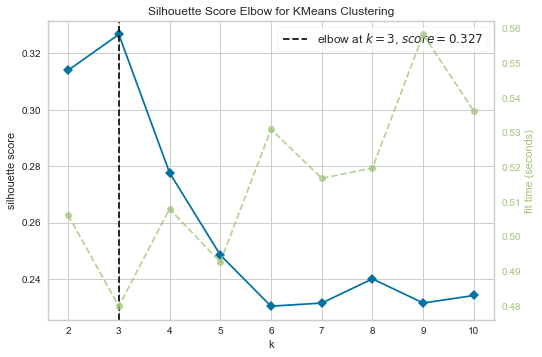

In [63]:
km = KMeans()
Elbow_M = KElbowVisualizer(estimator = km, k = 10, metric='silhouette')
Elbow_M.fit(data_pca)
Elbow_M.show()

plt.show()

In [64]:
km = KMeans(n_clusters=3, random_state=42)

yhat_AC = km.fit_predict(data_pca)

data_pca["Clusters"] = yhat_AC   # for evaluating the model
mk["Clusters"]= yhat_AC        # for customers profiling

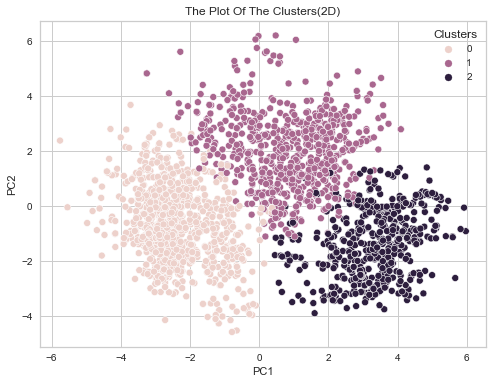

In [65]:
import seaborn as sns
#2차원

plt.figure(figsize=(8,6))

sns.scatterplot(data = data_pca, x = 'PC1', y='PC2', hue='Clusters')
plt.title('The Plot Of The Clusters(2D)')
plt.show()

클러스터별 개인정보

In [75]:
Personal = ["Income", "Days_Customer", "Age", "Kidhome","Teenhome", "Children", "Family_Size" ]

<Figure size 576x396 with 0 Axes>

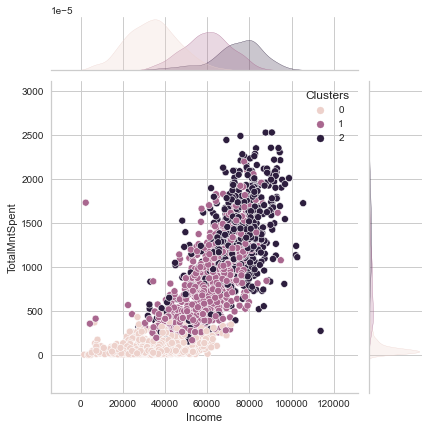

<Figure size 576x396 with 0 Axes>

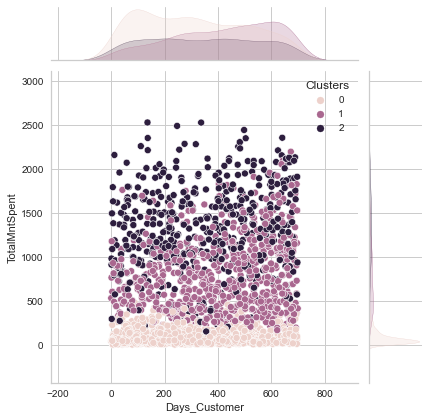

<Figure size 576x396 with 0 Axes>

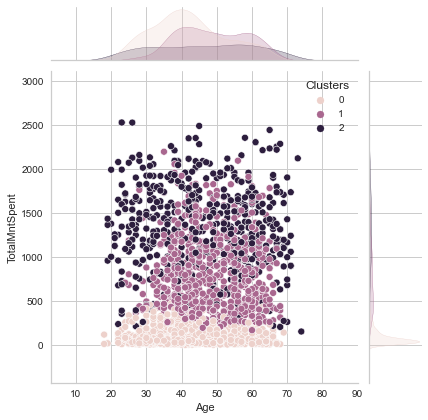

<Figure size 576x396 with 0 Axes>

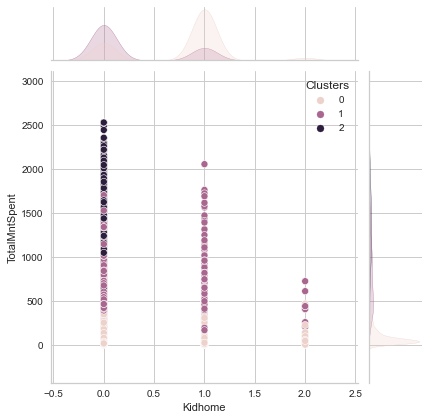

<Figure size 576x396 with 0 Axes>

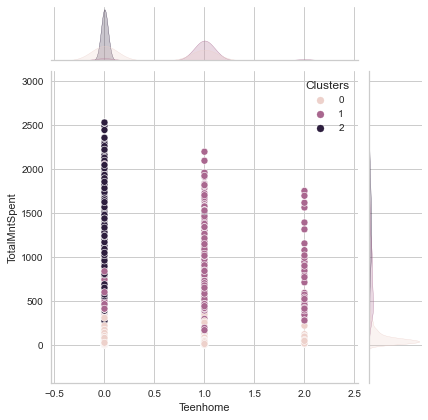

<Figure size 576x396 with 0 Axes>

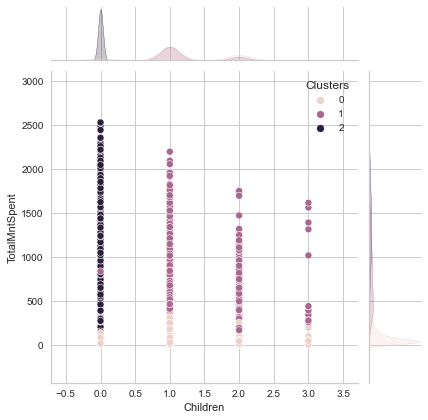

<Figure size 576x396 with 0 Axes>

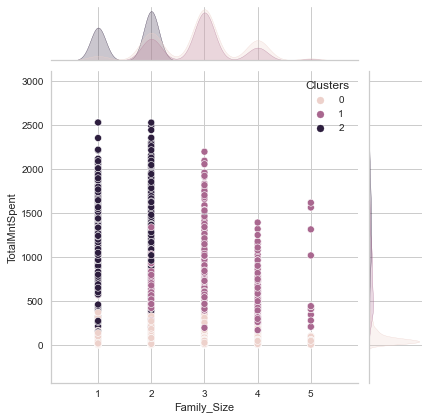

In [76]:
for i in Personal:
    plt.figure()
    sns.jointplot(x=mk[i], y=mk["TotalMntSpent"], hue =mk["Clusters"])
    plt.show()